In [3]:
from google.colab import files
uploaded = files.upload()

Saving influencers_data_3M.csv to influencers_data_3M.csv


**Step 1: Load Libraries**

In [4]:
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

**Step 2: Load the Dataset**

In [6]:
df = pd.read_csv("influencers_data_3M.csv")
df = df.dropna(subset=["content"])
df = df.reset_index(drop=True)


**Step 3: Initial Text Cleaning**

Purpose: remove obvious noise while preserving semantic meaning.

In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)      # remove URLs
    text = re.sub(r"@\w+", "", text)                # remove mentions
    text = re.sub(r"#", "", text)                   # keep hashtag words
    text = re.sub(r"[^a-z\s]", "", text)            # remove punctuation/emojis
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_content"] = df["content"].apply(clean_text)

**Step 4: Tokenization, Stopword Removal & Lemmatization**

This ensures topic interpretability.

In [8]:
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
custom_stopwords = {"link", "bio", "follow", "like", "share", "comment"}
stop_words = stop_words.union(custom_stopwords)

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token)
              for token in tokens
              if token not in stop_words and len(token) > 2]
    return " ".join(tokens)

df["processed_content"] = df["clean_content"].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [9]:
df.to_csv('out.csv')

In [10]:
df.shape

(5403, 11)

**Step 5: Remove Empty or Very Short Documents**

In [11]:
df = df[df["processed_content"].str.len() > 10]
df = df.reset_index(drop=True)

In [12]:
df.shape

(5363, 11)

In [13]:
df.to_csv('out2.csv')

**Step 6: Convert Text to Document-Term Matrix**

Using word frequency representation.

In [14]:
vectorizer = CountVectorizer(
    max_df=0.85,
    min_df=5,
    ngram_range=(1, 2)
)

doc_term_matrix = vectorizer.fit_transform(df["processed_content"])


**Step 7: Fit Topic Model**

Choose a reasonable number of topics (e.g., 10).

In [15]:
n_topics = 10

lda_model = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method="batch"
)

lda_model.fit(doc_term_matrix)

LatentDirichletAllocation(random_state=42)

**Step 8: Inspect Topics (Top Words per Topic)**

This is critical for manual labeling.

In [16]:
feature_names = vectorizer.get_feature_names_out()

def display_topics(model, feature_names, top_words=10):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[-top_words:]]
        topics[f"Topic {topic_idx}"] = top_features
    return topics

topics = display_topics(lda_model, feature_names)
topics


{'Topic 0': ['let',
  'mentoring',
  'angel',
  'vcs',
  'investor',
  'entrepreneurship',
  'roundtable',
  'founder',
  'entrepreneur',
  'startup'],
 'Topic 1': ['thing',
  'think',
  'need',
  'year',
  'day',
  'people',
  'life',
  'work',
  'time',
  'see'],
 'Topic 2': ['new',
  'whats',
  'est',
  'livestream',
  'business',
  'strategyhacker',
  'today',
  'data',
  'join',
  'see'],
 'Topic 3': ['get feedback',
  'mbym',
  'business',
  'mbym mentoring',
  'one',
  'brand',
  'feedback',
  'make',
  'see',
  'get'],
 'Topic 4': ['digitalhealth',
  'medicine',
  'time',
  'new',
  'digital',
  'technology',
  'healthcare',
  'future',
  'health',
  'see'],
 'Topic 5': ['covid',
  'trump',
  'many',
  'cpa',
  'get',
  'world',
  'gzero medium',
  'gzero',
  'medium',
  'see'],
 'Topic 6': ['business',
  'health',
  'economy',
  'banking',
  'technology',
  'vaccine',
  'bank',
  'india',
  'see',
  'covid'],
 'Topic 7': ['securitysolutions',
  'contact',
  'accesscontrol',
  

**Step 9: Assign Dominant Topic to Each Post**

In [17]:
topic_distribution = lda_model.transform(doc_term_matrix)
df["dominant_topic"] = topic_distribution.argmax(axis=1)


In [18]:
df.shape

(5363, 12)

In [20]:
df["topic_confidence"] = topic_distribution.max(axis=1)


In [21]:
df.to_csv('out_dominant_topic.csv')

**Step 10: Map Topic Numbers to Human-Readable Labels**

(Manual step informed by Step 8)

In [22]:
topic_labels = {
    0: "Fitness & Wellness",
    1: "Fashion & Beauty",
    2: "Travel & Experiences",
    3: "Food & Dining",
    4: "Lifestyle & Motivation",
    5: "Brand Promotions",
    6: "Technology & Tools",
    7: "Finance & Career",
    8: "Entertainment & Pop Culture",
    9: "Social Causes"
}

df["topic_label"] = df["dominant_topic"].map(topic_labels)


**Step 11: Topic Distribution (EDA)**

In [23]:
topic_counts = df["topic_label"].value_counts()
topic_counts


,count
topic_label,
Entertainment & Pop Culture,854
Lifestyle & Motivation,728
Fashion & Beauty,678
Brand Promotions,611
Fitness & Wellness,599
Technology & Tools,470
Food & Dining,454
Social Causes,452
Travel & Experiences,320


In [24]:
df.to_csv("influencer_topic_model_output.csv", index=False)


**Topic Modeling EDA — Step by Step**

Topic Distribution (LinkedIn-Relevant Topics)
What this shows

Which professional themes dominate LinkedIn-style content

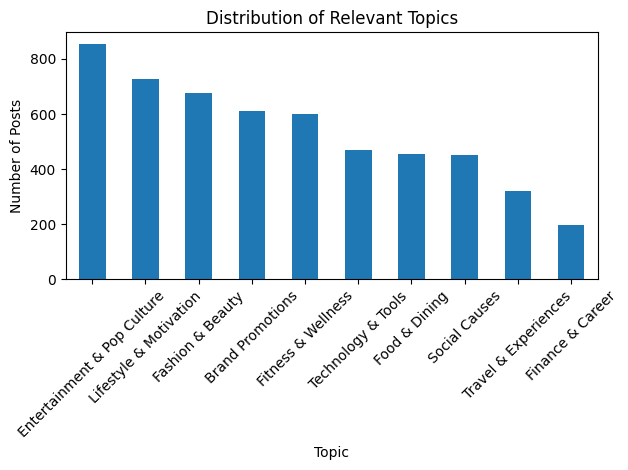

In [29]:
import matplotlib.pyplot as plt

topic_counts = df["topic_label"].value_counts()

plt.figure()
topic_counts.plot(kind="bar")
plt.title("Distribution of Relevant Topics")
plt.xlabel("Topic")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


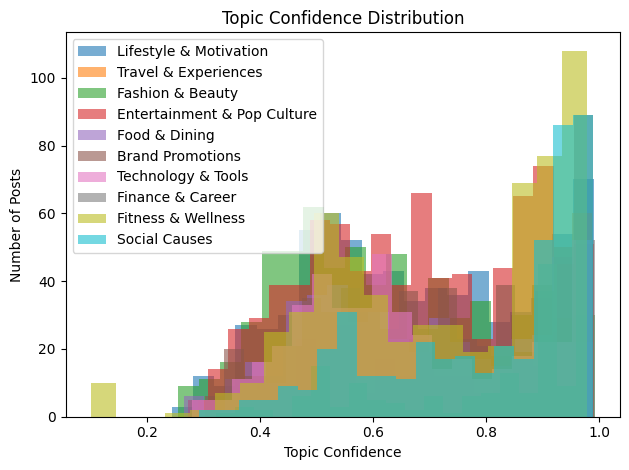

In [30]:
plt.figure()
for topic in df["topic_label"].unique():
    subset = df[df["topic_label"] == topic]
    plt.hist(subset["topic_confidence"], bins=20, alpha=0.6, label=topic)

plt.title("Topic Confidence Distribution")
plt.xlabel("Topic Confidence")
plt.ylabel("Number of Posts")
plt.legend()
plt.tight_layout()
plt.show()
